In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Imputing Missing Data

This time around, I'll be imputing `Age` and `Fare` in more detail. In theory, I won't know which data points will be missing, so I'll have to write the code that expects missing `Age` and `Fare` data and imputes them automatically.

In [3]:
imputation_agg = [
    'mean',
    'median',
    'count'
]

# Make a copy for analysis
impute_df = df_train.copy()

impute_df.groupby('Sex').Age.agg(imputation_agg)

,mean,median,count
Sex,,,
female,27.915709,27.0,261
male,30.726645,29.0,453


In [4]:
def extract_title(data):
    # Titles
    title_dict = {
        "Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
            "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
            "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
            "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty", "Dona": "Royalty"
    }
    Title_raw = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    return Title_raw.map(title_dict)

In [5]:
impute_df['Title'] = extract_title(impute_df)
impute_df.groupby('Title').Age.agg(imputation_agg)

,mean,median,count
Title,,,
Master,4.574167,3.5,36
Miss,21.804054,21.0,148
Mr,32.368090,30.0,398
Mrs,35.718182,35.0,110
Officer,56.600000,56.0,5
Royalty,42.294118,44.0,17


In [6]:
impute_df.groupby('Pclass').Age.mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [7]:
def impute_age(data, imputed_age_values):
    return imputed_age_values.loc[
        (imputed_age_values.Sex == data.Sex)
        & (imputed_age_values.Title == data.Title)
        & (imputed_age_values.Pclass == data.Pclass)
        & (imputed_age_values.Parch == data.Parch)
    ]

In [8]:
impute_df.groupby(['Pclass', 'Embarked']).Fare.agg(imputation_agg)

mean   median  count
Pclass Embarked                            
1      C         104.718529  78.2667     85
       Q          90.000000  90.0000      2
       S          70.364862  52.0000    127
2      C          25.358335  24.0000     17
       Q          12.350000  12.3500      3
       S          20.327439  13.5000    164
3      C          11.214083   7.8958     66
       Q          11.183393   7.7500     72
       S          14.644083   8.0500    353

In [9]:
def impute_fare(data, imputed_fare_values):
    return imputed_fare_values.loc[
        (imputed_fare_values.Pclass == data.Pclass)
        & (imputed_fare_values.Embarked == data.Embarked)
    ]

# Other Fields

I also want to see if I can do anything with the `Ticket` and `Cabin` fields.

In [10]:
df_train.Ticket.value_counts().sort_values(ascending=False).head(20)

347082          7
1601            7
CA. 2343        7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
4133            4
347077          4
19950           4
2666            4
W./C. 6608      4
113781          4
113760          4
349909          4
17421           4
PC 17757        4
LINE            4
35273           3
Name: Ticket, dtype: int64

# Feature Engineering / Data Cleaning

Given what I've learned about imputing `Age` and `Fare`, I'll be updating my `clean_data` function.

In [11]:
import re

# Utility Functions
def one_hot_encoding(data, field):
    ohe_fields = pd.get_dummies(data[field], prefix=field)
    for col in ohe_fields.columns.sort_values()[1:]:
        data[col] = ohe_fields[col]
    return data

# Clean Ticket
def clean_ticket(ticket_id):
    if ticket_id.isnumeric():
        return 'numeric'
    else:
        # return re.sub('[^A-Za-z]', '', ticket_id)
        return 'alphanumeric'

# Clean Cabin
def clean_cabin(cabin_id):
    if type(cabin_id) == float:
        return 'numeric'
    else:
        # return re.sub('[^A-Za-z]', '', cabin_id)
        return 'alphanumeric'

In [12]:
def clean_data(data, analysis=False):
    """
    Function for cleaning data
    """

    data_return = data.copy()

    # Create title field
    data_return['Title'] = extract_title(data_return)

    # Feature Engineer Ticket
    data_return['Ticket_split'] = data_return.Ticket.apply(lambda x: clean_ticket(x))

    # Feature Engineer Cabin
    data_return['Cabin_split'] = data_return.Cabin.apply(lambda x: clean_cabin(x))

    # Impute Age
    imputed_age_values = data_return.groupby(['Sex', 'Title', 'Pclass', 'Parch']).Age.mean()
    data_return['Age_cleaned'] = data_return.apply(lambda x: x.Age if pd.notna(x.Age) else imputed_age_values[x.Sex][x.Title][x.Pclass][x.Parch], axis=1)

    # Impute Age (Test Only)
    imputed_age_values_test = data_return.groupby(['Sex']).Age_cleaned.mean()
    data_return['Age_cleaned'] = data_return.apply(lambda x: x.Age_cleaned if pd.notna(x.Age_cleaned) else imputed_age_values_test[x.Sex], axis=1)

    # Impute Fare
    imputed_fare_values = data.groupby(['Pclass', 'Embarked']).Fare.mean()
    data_return['Fare_cleaned'] = data_return.apply(lambda x: x.Fare if pd.notna(x.Fare) else imputed_fare_values[x.Pclass][x.Embarked], axis=1)
    data_return['Fare_cleaned_sqrt'] = np.sqrt(data_return['Fare_cleaned'])
    
    # One-Hot Encoding
    data_return = one_hot_encoding(data_return, 'Title')
    data_return = one_hot_encoding(data_return, 'Embarked')
    data_return = one_hot_encoding(data_return, 'Sex')
    data_return = one_hot_encoding(data_return, 'Ticket_split')
    data_return = one_hot_encoding(data_return, 'Cabin_split')
    data_return = one_hot_encoding(data_return, 'Pclass')

    # Simplify SibSp
    data_return['Has_SibSp'] = data_return.SibSp.apply(lambda x: 1 if x > 0 else 0)

    # Simplify Parch
    data_return['Has_Parch'] = data_return.Parch.apply(lambda x: 1 if x > 0 else 0)

    # Interaction variables
    data_return['Sex_and_Parch'] = data_return.Sex_male * data_return.Has_Parch
    data_return['Has_SibSp_and_Parch'] = data_return.Has_SibSp * data_return.Has_Parch
    data_return['Sex_and_Fare'] = data_return.Sex_male * data_return.Fare_cleaned

    # Normalize Age + Fare
    data_return.Age_cleaned = (data_return.Age_cleaned - data_return.Age_cleaned.mean()) / data_return.Age_cleaned.std()
    data_return.Fare_cleaned = (data_return.Fare_cleaned - data_return.Fare_cleaned.mean()) / data_return.Fare_cleaned.std()
    data_return.Fare_cleaned_sqrt = (data_return.Fare_cleaned_sqrt - data_return.Fare_cleaned_sqrt.mean()) / data_return.Fare_cleaned_sqrt.std()

    if analysis:
        return data_return
    else:
        # Drop columns
        dropped_columns = [
            'PassengerId',
            'Ticket',
            'Ticket_split',
            'Cabin',
            'Cabin_split',
            'Name',
            'Title',
            'Sex',
            'Embarked',
            'Age',
            'Fare',
            'Pclass',
            'SibSp',
            'Parch'
        ]

        data_return.drop(dropped_columns, axis=1, inplace=True)

        return data_return

In [13]:
df_train_cleaned = clean_data(df_train)
df_train_cleaned.head()

,Survived,Age_cleaned,Fare_cleaned,Fare_cleaned_sqrt,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_Q,...,Sex_male,Ticket_split_numeric,Cabin_split_numeric,Pclass_2,Pclass_3,Has_SibSp,Has_Parch,Sex_and_Parch,Has_SibSp_and_Parch,Sex_and_Fare
0,0,-0.552874,-0.502163,-0.732705,0,1,0,0,0,0,...,1,0,1,0,1,1,0,0,0,7.25
1,1,0.628214,0.786404,1.219137,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.00
2,1,-0.257602,-0.488580,-0.691106,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0.00
3,1,0.406760,0.420494,0.826767,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0.00
4,0,0.406760,-0.486064,-0.683600,0,1,0,0,0,0,...,1,1,1,0,1,0,0,0,0,8.05


In [14]:
test_data = pd.read_csv('data/test.csv')
test_data_cleaned = clean_data(test_data)
test_data_cleaned.head()

,Age_cleaned,Fare_cleaned,Fare_cleaned_sqrt,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_Q,Embarked_S,Sex_male,Ticket_split_numeric,Cabin_split_numeric,Pclass_2,Pclass_3,Has_SibSp,Has_Parch,Sex_and_Parch,Has_SibSp_and_Parch,Sex_and_Fare
0,0.364189,-0.496790,-0.696411,0,1,0,0,0,1,0,1,1,1,0,1,0,0,0,0,7.8292
1,1.325197,-0.511637,-0.743908,0,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0,0.0000
2,2.478406,-0.463518,-0.598373,0,1,0,0,0,1,0,1,1,1,1,0,0,0,0,0,9.6875
3,-0.212416,-0.481870,-0.651153,0,1,0,0,0,0,1,1,1,1,0,1,0,0,0,0,8.6625
4,-0.596819,-0.416965,-0.475865,0,0,1,0,0,0,1,0,1,1,0,1,1,1,0,1,0.0000


In [15]:
# Ensure all columns are available in both
missing_in_trained = list(set(test_data_cleaned.columns) - set(df_train_cleaned.columns))
missing_in_test = list(set(df_train_cleaned.columns) - set(test_data_cleaned.columns))

for col in missing_in_trained:
    if col not in df_train_cleaned.columns:
        df_train_cleaned[col] = 0

for col in missing_in_test:
    if col not in test_data_cleaned.columns:
        test_data_cleaned[col] = 0

In [16]:
# Test that both test & train have the same columns
print('Missing in Trained:', list(set(df_train_cleaned.columns) - set(test_data_cleaned.columns)))
print('Missing in Test:', list(set(test_data_cleaned.columns) - set(df_train_cleaned.columns)))

Missing in Trained: []
Missing in Test: []


In [17]:
test_data_cleaned.drop('Survived', axis=1, inplace=True)

# Model Selection

In my previous attempt, I only used Logistic Regression with an L2 regularization. The default solver for both `statsmodels` and `scikit-learn` is maximum likelihood and L-BFGS respectively. 

Since `statsmodels` doesn't have a validation suite, I can't easily use k-Folds without building something on my own. For now, I'll use `scikit-learn` and play around with the model hyperparameters using `GridSearchCV`.

Theoretically, L1 and L2 work similarly, except L1 forces the coefficients to be 0, making L1 norm more preferrable as it works similar to best subset selection. However, I'll check both just to see if there are any differences.

Cross Validation Score Mean after Repeated K-Fold: 82.00%
Cross Validation Score Std. Dev. after Repeated K-Fold: 0.03


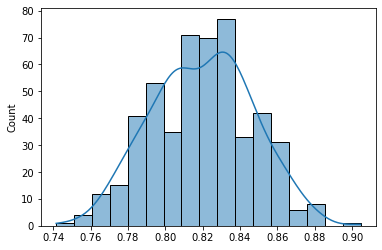

In [18]:
X = df_train_cleaned.drop('Survived', axis=1).copy()
y = df_train_cleaned.Survived.copy()

cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=654237)
m01 = LogisticRegression(penalty='l1', solver='liblinear', C=2.782559402207126)
m01.fit(X, y)

scores = cross_val_score(m01, X, y, scoring='accuracy', cv=cv, n_jobs=-10)

sns.histplot(x=scores, kde=True)

print('Cross Validation Score Mean after Repeated K-Fold: {:0.2f}%'.format(np.mean(scores)*100))
print('Cross Validation Score Std. Dev. after Repeated K-Fold: {:0.2f}'.format(np.std(scores)))

In [19]:
param_grid = [
    {
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'C' : np.logspace(-4, 4, 10),
        'solver' : ['liblinear', 'saga']
    }
]

log_reg_grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10)
log_reg_grid_search.fit(X, y)

/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear', 'saga']}])

In [20]:
log_reg_grid_search.best_params_

{'C': 21.54434690031882, 'penalty': 'l2', 'solver': 'liblinear'}

In [21]:
log_reg_grid_search.best_score_

0.8238077403245943

In [22]:
m02 = LogisticRegression(
    penalty=log_reg_grid_search.best_params_['penalty'],
    solver=log_reg_grid_search.best_params_['solver'],
    C=log_reg_grid_search.best_params_['C']
)

m02.fit(X, y)

LogisticRegression(C=21.54434690031882, solver='liblinear')

# Potential Improvements

- There are huge outliers in Fare that we can ignore or replace with imputed values
- We can test the logistic regression model to see if the data violates the following assumptions:
    - Response variable is binary (don't need to test this one)
    - Linear relationship between the predictors and the log-odds
    - Observations are independent
    - No severe multicollinearity
    - There are no extreme outliers (as stated above)

In [23]:
# @TODO: Create logit statsmodels with best hyper-parameters above and analyze results
# Check for linearity between predictor and logit
all_columns = ' + '.join(df_train_cleaned.columns.drop('Survived'))

m03 = smf.logit(formula='{} ~ {}'.format('Survived', all_columns), data=df_train_cleaned).fit_regularized()
print(m03.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.41441374162974454
            Iterations: 180
            Function evaluations: 183
            Gradient evaluations: 180
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      870
Method:                           MLE   Df Model:                           20
Date:                Sun, 15 May 2022   Pseudo R-squ.:                  0.3777
Time:                        11:40:39   Log-Likelihood:                -369.24
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.963e-82
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [24]:
df_train_cleaned.describe()

,Survived,Age_cleaned,Fare_cleaned,Fare_cleaned_sqrt,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_Q,...,Sex_male,Ticket_split_numeric,Cabin_split_numeric,Pclass_2,Pclass_3,Has_SibSp,Has_Parch,Sex_and_Parch,Has_SibSp_and_Parch,Sex_and_Fare
count,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,-4.846354e-15,7.437622e-16,1.579108e-15,0.206510,0.580247,0.142536,0.005612,0.020202,0.086420,...,0.647587,0.741863,0.771044,0.206510,0.551066,0.317621,0.239057,0.104377,0.159371,16.528941
std,0.486592,1.000000e+00,1.000000e+00,1.000000e+00,0.405028,0.493796,0.349796,0.074743,0.140770,0.281141,...,0.477990,0.437855,0.420397,0.405028,0.497665,0.465813,0.426747,0.305921,0.366228,36.785977
min,0.000000,-2.145867e+00,-6.480577e-01,-1.646647e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-5.751915e-01,-4.888737e-01,-6.919874e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-4.374211e-02,-3.571902e-01,-3.561810e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.829200
75%,1.000000,5.359412e-01,-2.423274e-02,2.432165e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,15.645850
max,1.000000,3.728570e+00,9.661740e+00,6.036236e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,512.329200


In [25]:
df_train_analysis = clean_data(df_train, analysis=True)

In [26]:
m02_y_pred = m02.predict_proba(df_train_cleaned.drop('Survived', axis=1)).reshape(2, -1)[1]
m02_y_log_odds = np.log(m02_y_pred / (1 - m02_y_pred))

In [27]:
m02.classes_

array([0, 1])

<AxesSubplot:>

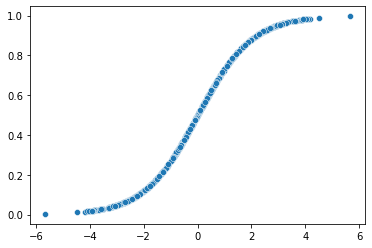

In [28]:
# Check if Logit is calculated correctly
sns.scatterplot(
    x=m02_y_log_odds,
    y=m02_y_pred
)

<AxesSubplot:xlabel='Fare_cleaned_sqrt'>

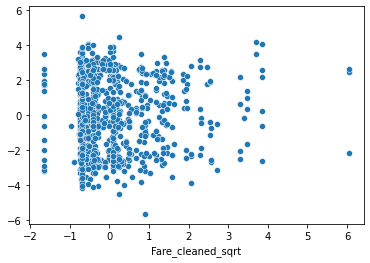

In [29]:
sns.scatterplot(
    x=df_train_analysis.Fare_cleaned_sqrt,
    y=m02_y_log_odds
)

<AxesSubplot:ylabel='Age_cleaned'>

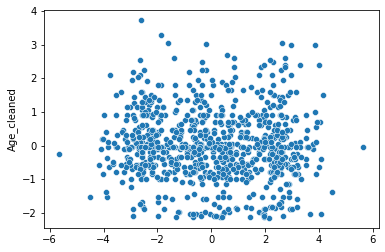

In [30]:
sns.scatterplot(
    x=m02_y_log_odds,
    y=df_train_analysis.Age_cleaned,
)

/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare_cleaned', ylabel='Density'>

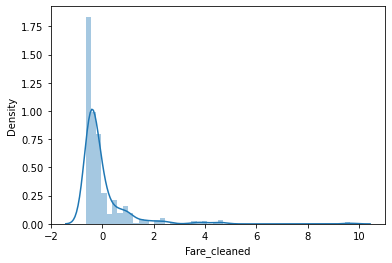

In [31]:
sns.distplot(df_train_analysis.Fare_cleaned)

/Users/arielongoco/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age_cleaned', ylabel='Density'>

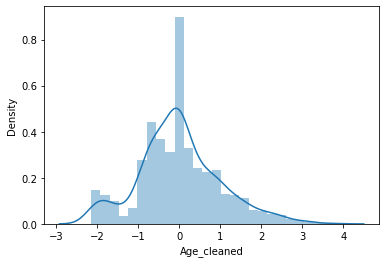

In [32]:
sns.distplot(df_train_analysis.Age_cleaned)

# Exporting Results

In [33]:
m02_test_pred = m02.predict(test_data_cleaned)
m02_test_pred[0:10]

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0])

In [34]:
m02_test_pred_df = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': m02_test_pred})
m02_test_pred_df.to_csv('submissions/20220511_submission.csv', index=False)